Работа с временными рядами.
    
Известно ежемесячное число смертей в результате несчастного случая в США с января 1973 по декабрь 1978, необходимо построить прогноз на следующие 2 года. Ожидаю в конце уидеть график.
При выполнении работ напишите введение и вывод.Посторайтесь коментировать то что делаете.

In [59]:


import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import re

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.statespace.sarimax import SARIMAX

sns.set_style("darkgrid")

In [60]:
df = pd.read_csv("accidental-deaths-in-usa-monthly.csv")
df.head(3)

,Month,"Accidental deaths in USA: monthly, 1973 ? 1978"
0,1973-01,9007
1,1973-02,8106
2,1973-03,8928


In [61]:
df.shape

(72, 2)

In [62]:
display(df.info())
display(df.tail(2))
display(df.describe().T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 2 columns):
 #   Column                                          Non-Null Count  Dtype 
---  ------                                          --------------  ----- 
 0   Month                                           72 non-null     object
 1   Accidental deaths in USA: monthly, 1973 ? 1978  72 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.2+ KB


None

,Month,"Accidental deaths in USA: monthly, 1973 ? 1978"
70,1978-11,8633
71,1978-12,9240


,count,mean,std,min,25%,50%,75%,max
"Accidental deaths in USA: monthly, 1973 ? 1978",72.0,8787.736111,958.338013,6892.0,8089.0,8728.5,9323.25,11317.0


In [63]:
# Для удобства работы с названиемя столбцов приведём их к единому виду убрав пробелы и спецсимволы
df.columns = [re.sub('\s|\-|\,|\?', '_', col) for col in map(str.lower, df.columns)]
df.columns

Index(['month', 'accidental_deaths_in_usa:_monthly__1973___1978'], dtype='object')

In [64]:
X=df[['accidental_deaths_in_usa:_monthly__1973___1978']].ffill()

In [65]:
# Учитывая уникальность значений месяцев сделаем их индексами нашей таблицы
X_dt = df.set_index(["month"])

In [66]:
# Приведём индексы к формату datetime, это позволит более комфортно работать с таблицей 
X_dt.index = pd.to_datetime(X_dt.index)

In [67]:
endog = X_dt["accidental_deaths_in_usa:_monthly__1973___1978"]

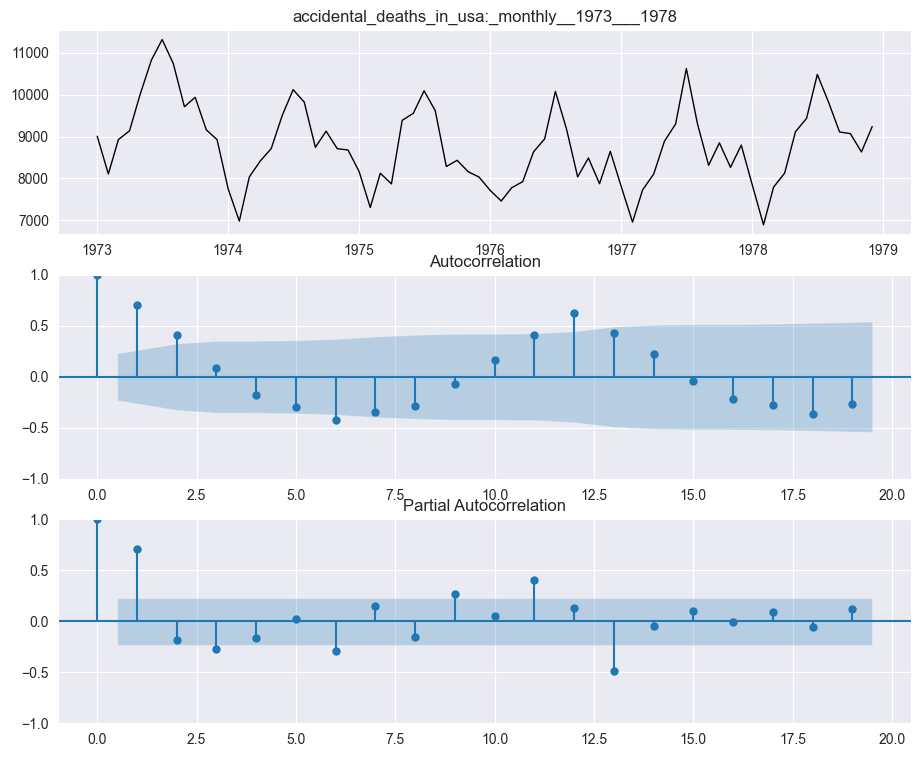

In [68]:
# Посмотрим нашу модель на предмет стационарности
fig, (ax_endog, ax_acf, ax_pacf) = plt.subplots(nrows=3, figsize=(11, 9))
ax_endog.plot(endog, c="black", lw=1)
ax_endog.set(title="accidental_deaths_in_usa:_monthly__1973___1978")
plot_acf(x=endog, ax=ax_acf)
plot_pacf(x=endog, ax=ax_pacf)

plt.show()

На лицо наличие признаков стационарности, значит можно пробовать применять модель SARIMAX

In [69]:
# Разделим выборку на обучающую и тестовую для того, чтоб посмотреть как работает наша модель
X_train, X_test = X_dt.loc[:"1977-12"], X_dt.loc["1978-01":]

train_endog, test_endog = endog.loc[:"1977-12"], endog.loc["1978-01":]

In [70]:
# сформируем модель для обучения
sarima = SARIMAX(endog=train_endog, order=(3, 1, 3), seasonal_order=(1, 1, 0, 12)).fit()

C:\Users\SergS\miniconda3\envs\cuda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\SergS\miniconda3\envs\cuda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\SergS\miniconda3\envs\cuda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\SergS\miniconda3\envs\cuda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\SergS\miniconda3\envs\cuda\lib\site-packages\stats

In [71]:
# Сделаем предсказание на один год, чтоб сравнить с тестовым набором
pred_sarima = sarima.forecast(steps=len(test_endog))
pred_sarima

1978-01-01     7911.387258
1978-02-01     7178.247442
1978-03-01     7913.871759
1978-04-01     7932.617080
1978-05-01     8670.734360
1978-06-01     9180.149009
1978-07-01    10158.657374
1978-08-01     9105.895079
1978-09-01     8138.928141
1978-10-01     8389.820035
1978-11-01     7961.317126
1978-12-01     8604.946177
Freq: MS, Name: predicted_mean, dtype: float64

In [72]:
pred_sarima.index = pd.to_datetime(pred_sarima.index)

C:\Users\SergS\AppData\Local\Temp\ipykernel_8816\494219487.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


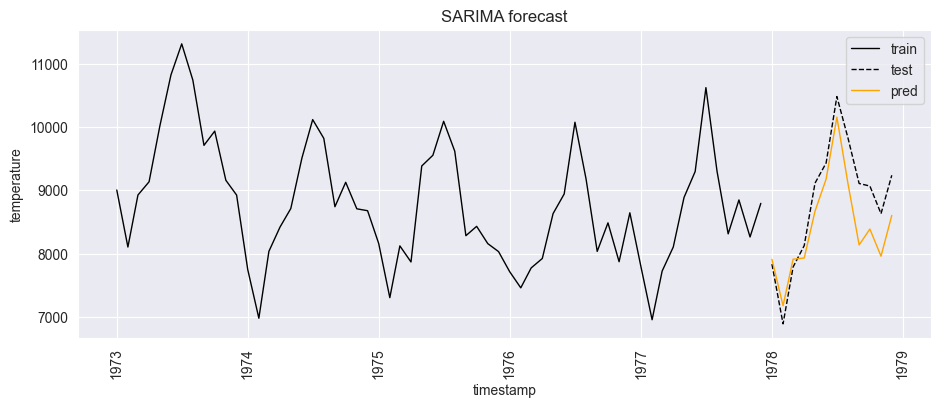

In [73]:
# Отрисуем графики, чтобы наглядно видеть отличия предсказания с тестовой выборкой
fig, ax = plt.subplots(figsize=(11, 4))
ax.plot(train_endog, c="black", lw=1, label="train")
ax.plot(test_endog, c="black", lw=1, ls='--', label="test")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.plot(pred_sarima, c="orange", lw=1, label="pred")
ax.legend()

ax.set(title="SARIMA forecast", xlabel="timestamp", ylabel="temperature")
plt.show()

In [74]:
# Обучим модель уже на всех данных, чтоб сделать предсказание на будущее 
sarima = SARIMAX(endog=X_dt, order=(3, 1, 3), seasonal_order=(1, 1, 0, 12)).fit()

C:\Users\SergS\miniconda3\envs\cuda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\SergS\miniconda3\envs\cuda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\SergS\miniconda3\envs\cuda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\SergS\miniconda3\envs\cuda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\SergS\miniconda3\envs\cuda\lib\site-packages\stats

In [75]:
# предсказываем на будущие 2 года
pred_sarima = sarima.forecast(steps=24)
pred_sarima

1979-01-01     8055.921734
1979-02-01     7348.056433
1979-03-01     8012.980104
1979-04-01     8208.494824
1979-05-01     9319.306817
1979-06-01     9446.866057
1979-07-01    10561.647192
1979-08-01     9812.412796
1979-09-01     8722.110143
1979-10-01     8974.898804
1979-11-01     8607.914403
1979-12-01     8919.634354
1980-01-01     7966.981755
1980-02-01     7216.308102
1980-03-01     7741.537583
1980-04-01     8196.049207
1980-05-01     9226.280348
1980-06-01     9248.823336
1980-07-01    10567.377709
1980-08-01     9748.000687
1980-09-01     8701.927882
1980-10-01     9062.203425
1980-11-01     8491.533555
1980-12-01     8898.950300
Freq: MS, Name: predicted_mean, dtype: float64

C:\Users\SergS\AppData\Local\Temp\ipykernel_8816\3033431715.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


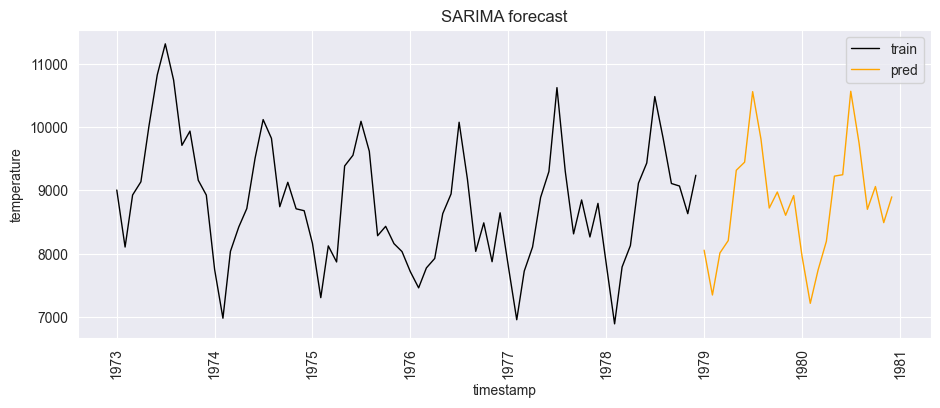

In [76]:
# отрисовываем графики предсказания
fig, ax = plt.subplots(figsize=(11, 4))
ax.plot(X_dt, c="black", lw=1, label="train")

ax.plot(pred_sarima, c="orange", lw=1, label="pred")
ax.legend()
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set(title="SARIMA forecast", xlabel="timestamp", ylabel="temperature")
plt.show()